# Topic Extraction in RSS-Feed Corpus

- Author:      Johannes Maucher
- Last update: 2018-11-16

In the [notebook 01gensimDocModelSimple](01gensimDocModelSimple.ipynb) the concepts of dictionaries, document models, tf-idf and similarity have been described using an example of a samll document collection. Moreover, in [notebook 02LatentSemanticIndexing](02LatentSemanticIndexing.ipynb) LSI based topic extraction and document clustering have also been introduced by a small playground example.

The current notebook applies these concepts to a real corpus of RSS-Feeds, which has been generated and accessed in previous notebooks of this lecture:

## Read documents from a corpus 

The contents of the RSS-Fedd corpus are imported by NLTK's `CategorizedPlaintextCorpusReader` as already done in previous notebooks of this lecture:

In [4]:
#!pip install wordcloud

In [5]:
from nltk.corpus.reader import CategorizedPlaintextCorpusReader
from nltk.corpus import stopwords
stopwordlist=stopwords.words('german')
from wordcloud import WordCloud

rootDir="../01access/GERMAN"
filepattern=r"(?!\.)[\w_]+(/RSS/FeedText/)[\w-]+/[\w-]+\.txt"
#filepattern=r"(?!\.)[\w_]+(/RSS/FullText/)[\w-]+/[\w-]+\.txt"
catpattern=r"([\w_]+)/.*"
rssreader=CategorizedPlaintextCorpusReader(rootDir,filepattern,cat_pattern=catpattern)

In [6]:
singleDoc=rssreader.paras(categories="TECH")[0]
print("The first paragraph:\n",singleDoc)
print("Number of paragraphs in the corpus: ",len(rssreader.paras(categories="TECH")))

The first paragraph:
 [['Zur', 'kalten', 'Jahreszeit', 'nur', '1', '%', 'Akku', '?'], ['Dieser', 'Befehl', 'hält', 'den', 'iPhone', '-', 'Akku', 'länger', 'am', 'Leben', 'Im', 'Auto', ',', 'bei', 'einem', 'wichtigen', 'Anruf', 'oder', 'wenn', 'man', 'abends', 'unterwegs', 'ist', ':', 'Der', 'Akku', 'des', 'Smartphones', 'geht', 'immer', 'dann', 'leer', ',', 'wenn', 'man', 'ihn', 'am', 'dringendsten', 'braucht', '.'], ['Wir', 'zeigen', 'Ihnen', 'einen', 'praktischen', 'Trick', ',', 'mit', 'dem', 'Sie', 'die', 'Laufzeit', 'Ihres', 'iPhones', 'auch', 'bei', 'niedrigem', 'Batteriestand', 'verlängern', 'können', '.']]
Number of paragraphs in the corpus:  160


In [7]:
techdocs=[[w.lower() for sent in singleDoc for w in sent if (len(w)>1 and w.lower() not in stopwordlist)] for singleDoc in rssreader.paras(categories="TECH")]
print("Number of documents in category Tech: ",len(techdocs))

Number of documents in category Tech:  160


In [8]:
generaldocs=[[w.lower() for sent in singleDoc for w in sent if (len(w)>1 and w.lower() not in stopwordlist)] for singleDoc in rssreader.paras(categories="GENERAL")]
print("Number of documents in category General: ",len(generaldocs))

Number of documents in category General:  334


In [9]:
alldocs=techdocs+generaldocs
print("Total number of documents: ",len(alldocs))

Total number of documents:  494


### Remove duplicate news

In [10]:
def removeDuplicates(nestedlist):
    listOfTuples=[tuple(liste) for liste in nestedlist]
    uniqueListOfTuples=list(set(listOfTuples))
    return [list(menge) for menge in uniqueListOfTuples]

In [11]:
techdocs=removeDuplicates(techdocs)
generaldocs=removeDuplicates(generaldocs)
alldocs=removeDuplicates(alldocs)
print("Number of unique documents in category Tech: ",len(techdocs))
print("Number of unique documents in category General: ",len(generaldocs))
print("Total number of unique documents: ",len(alldocs))

Number of unique documents in category Tech:  160
Number of unique documents in category General:  285
Total number of unique documents:  445


In [12]:
alltechString=" ".join([w for doc in techdocs for w in doc])
print(len(alltechString))
allgeneralString=" ".join([w for doc in generaldocs for w in doc])
print(len(allgeneralString))

30680
53511


(-0.5, 399.5, 199.5, -0.5)

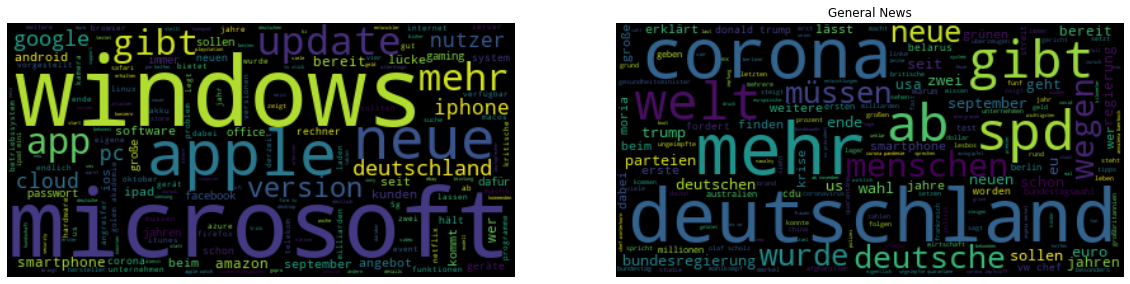

In [13]:
wordcloudTech=WordCloud().generate(alltechString)
wordcloudGeneral=WordCloud().generate(allgeneralString)
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,18))
plt.title("Tech News")
plt.subplot(1,2,1)
plt.imshow(wordcloudTech, interpolation='bilinear')
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(wordcloudGeneral, interpolation='bilinear')
plt.title("General News")
plt.axis("off")

## Gensim-representation of imported RSS-feeds 

In [14]:
from gensim import corpora, models, similarities
dictionary = corpora.Dictionary(alldocs)
dictionary.save('feedwordsDE.dict') # store the dictionary, for future reference
#print(dictionary.token2id)
print(len(dictionary))

4845


In [16]:
firstdoc=techdocs[0]
print(firstdoc)
firstVec = dictionary.doc2bow(firstdoc)
print("Sparse BoW representation of single document: %s"%firstVec)
w1='windows'
w2='apple'
w3='system'
print("Index of word %s is %d"%(w1,dictionary.token2id[w1]))
print("Index of word %s is %d"%(w2,dictionary.token2id[w2]))
print("Index of word %s is %d"%(w3,dictionary.token2id[w3]))

['fritzbox', '6850', '5g', 'erster', 'avm', 'router', '5g', 'mobilfunk', 'erhältlich', 'zwei', 'jahre', 'ankündigung', 'kommt', 'avms', 'erster', 'router', 'internet', 'per', '5g', 'mobilfunk', 'endlich', 'deutschen', 'markt', 'gesalzenen', 'preis']
Sparse BoW representation of single document: [(224, 1), (481, 1), (488, 1), (511, 1), (523, 1), (564, 1), (668, 1), (888, 1), (1044, 2), (1497, 1), (1843, 3), (1844, 1), (1845, 1), (1846, 1), (1847, 1), (1848, 1), (1849, 1), (1850, 1), (1851, 2), (1852, 2)]
Index of word windows is 133
Index of word apple is 205
Index of word system is 529


Sparse BoW representation of entire tech-corpus and entire general-news-corpus: 

In [17]:
techcorpus = [dictionary.doc2bow(doc) for doc in techdocs]
generalcorpus = [dictionary.doc2bow(doc) for doc in generaldocs]

In [18]:
print(generaldocs[:3])

[['alexander', 'lukaschenko', 'volksversammlung', 'neuwahlen', 'belarus', 'entscheiden', 'autoritäre', 'staatschef', 'gremium', 'neuwahlen', 'nächsten', 'jahr', 'entscheiden', 'lassen', 'indessen', 'führende', 'oppositionelle', 'festgenommen', 'worden', 'geflohen'], ['csu', 'generalsekretär', 'blume', 'fordert', 'cdu', 'fehleranalyse', 'kurz', 'bundestagswahl', 'rechnet', 'csu', 'generalsekretär', 'markus', 'blume', 'knappen', 'ergebnis', 'spricht', 'schon', 'notwendigen', 'erkenntnissen', '“,', 'ziehen', 'seien'], ['newsletter', 'finanzen', 'chinesische', 'riese', 'wackelt', 'geist', 'evergrande', 'weht', 'parkett', 'handelsstart', 'runderneuerten', 'leitindex', 'vorerst', 'verlusten', 'beginnt', 'wichtig', 'steht', 'neuen', '.-', 'newsletter', 'finanzen', '“.']]


## Find similiar documents

In [19]:
index = similarities.SparseMatrixSimilarity(techcorpus, num_features=len(dictionary))

In [20]:
sims = index[firstVec]
#print(list(enumerate(sims)))
simlist = sims.argsort()
print(simlist)
mostSimIdx=simlist[-2]

[159 108 107 106 103 100  99  98  97  96  95  94  92  91  90  89  88  87
  73  74 150  76  77  78 109 158  81  82  83  84  85  86 155 110 111 113
 134 135 136 137 138 140 133 141 144 145 152 147 148 149 142  72 132 129
 114 153 116 117 118 120 130 121 123 124 125 126 127 128 122  71  75  34
  37  35  70 157  32  31  30  29  28  27  24  22  21  20  18  17  16  15
  14  13  10   9   8   7   6   5   4   3   1  38  39 151  53  55  51  56
  50  58  59  49  60  48  61  40  47  45  44  62  43  63  64  41  65  66
  68  46  54 104  42  93   2  69  52  26 139 102 105 131 112  67 154  19
  36  23  12  25 119 143  11 156  79  80  57 101 115  33 146   0]


In [21]:
print("Refernce document is:\n",firstdoc)
print("Most similar document:\n",techdocs[mostSimIdx])

Refernce document is:
 ['fritzbox', '6850', '5g', 'erster', 'avm', 'router', '5g', 'mobilfunk', 'erhältlich', 'zwei', 'jahre', 'ankündigung', 'kommt', 'avms', 'erster', 'router', 'internet', 'per', '5g', 'mobilfunk', 'endlich', 'deutschen', 'markt', 'gesalzenen', 'preis']
Most similar document:
 ['statistik', 'woche', 'deutschen', 'ausbau', '5g', 'netzes', 'sehen', '5g', 'anschlüsse', 'nehmen', 'weltweit', 'trauen', 'technologie', 'infografik', 'zeigt']


## Find topics by Latent Semantic Indexing (LSI)
### Generate tf-idf model of corpus

In [22]:
tfidf = models.TfidfModel(techcorpus)
corpus_tfidf = tfidf[techcorpus]
print("Display TF-IDF- Model of first 2 documents of the corpus")
for doc in corpus_tfidf[:2]:
    print(doc)

Display TF-IDF- Model of first 2 documents of the corpus
[(224, 0.1006892773791535), (481, 0.11924041066162697), (488, 0.18430991222408263), (511, 0.14441273000641533), (523, 0.18430991222408263), (564, 0.1339652735345059), (668, 0.12586159672394187), (888, 0.11924041066162697), (1044, 0.28882546001283066), (1497, 0.1339652735345059), (1843, 0.4774127786378828), (1844, 0.18430991222408263), (1845, 0.18430991222408263), (1846, 0.18430991222408263), (1847, 0.18430991222408263), (1848, 0.18430991222408263), (1849, 0.18430991222408263), (1850, 0.18430991222408263), (1851, 0.36861982444816527), (1852, 0.36861982444816527)]
[(75, 0.12092454245130003), (151, 0.06358431360137216), (158, 0.09820260027258683), (205, 0.26016591768049724), (325, 0.12092454245130003), (541, 0.10257987059460763), (870, 0.11360971089356608), (891, 0.10763305833319844), (909, 0.3327368536174529), (1049, 0.22721942178713217), (1051, 0.24184908490260007), (1112, 0.12092454245130003), (1172, 0.13035500051191165), (1245, 

### Generate LSI model from tf-idf model

In [23]:
techdictionary = corpora.Dictionary(techdocs)

In [40]:
NumTopics=20
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=NumTopics) # initialize an LSI transformation

/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
corpus_lsi = lsi[corpus_tfidf]

/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Display first 10 topics:

In [42]:
lsi.print_topics(10)

/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.413*"windows" + 0.403*"microsoft" + 0.362*"11" + 0.131*"apple" + 0.115*"oktober" + 0.114*"neue" + 0.112*"office" + 0.106*"nutzer" + 0.101*"betriebssystem" + 0.101*"10"'),
 (1,
  '-0.504*"apple" + -0.278*"ipad" + 0.205*"microsoft" + -0.202*"15" + -0.181*"mini" + -0.160*"watch" + -0.151*"ios" + 0.126*"11" + -0.123*"homepod" + -0.112*"tvos"'),
 (2,
  '-0.337*"azure" + -0.267*"linux" + 0.243*"11" + -0.243*"cloud" + 0.232*"windows" + -0.184*"lücke" + -0.179*"kritische" + -0.174*"omigod" + -0.150*"updates" + -0.139*"kunden"'),
 (3,
  '0.284*"google" + 0.250*"android" + 0.225*"12" + -0.178*"ipad" + 0.146*"version" + -0.143*"microsoft" + 0.138*"deutschland" + 0.136*"itunes" + 0.135*"firefox" + -0.127*"mini"'),
 (4,
  '-0.409*"ipad" + -0.210*"test" + 0.204*"apple" + -0.204*"mini" + -0.194*"apples" + -0.194*"praxis" + -0.158*"10" + -0.137*"deal" + 0.128*"watch" + -0.125*"leistung"'),
 (5,
  '0.218*"google" + 0.207*"12" + 0.202*"android" + 0.189*"11" + 0.151*"itunes" + -0.150*"office" +

### Determine the most relevant documents for a selected topic

Generate a numpy array `docTopic`. The entry in row $i$, column $j$ of this array is the relevance value for topic $j$ in document $i$.

In [27]:
import numpy as np
numdocs= len(corpus_lsi)
docTopic=np.zeros((numdocs,NumTopics))

In [28]:
for d,doc in enumerate(corpus_lsi): # both bow->tfidf and tfidf->lsi transformations are actually executed here, on the fly
    for t,top in enumerate(doc):
        docTopic[d,t]=top[1]
print(docTopic.shape)
print(docTopic)

(160, 50)
[[-0.03803016  0.02718004  0.02338531 ... -0.02754874  0.02699487
  -0.05277636]
 [-0.12977387  0.38270119 -0.04255238 ...  0.03338141  0.00329523
   0.05607268]
 [-0.04454105  0.01753761  0.01542037 ...  0.14002722 -0.03503906
  -0.15972926]
 ...
 [-0.01379596  0.01590744 -0.02149224 ... -0.0195454   0.00946071
  -0.00508891]
 [-0.03654358  0.02897084 -0.00275673 ... -0.06731113 -0.07043221
  -0.11607102]
 [-0.07991011  0.00160016 -0.10608843 ...  0.09926719 -0.02462228
   0.07509958]]


Select an arbitrary topic-id and determine the documents, which have the highest relevance value for this topic:

In [29]:
topicId=7 #select an arbitrary topic-id
topicRelevance=docTopic[:,topicId]

In [30]:
docsoftopic= np.array(topicRelevance).argsort()
relevanceValue= np.sort(topicRelevance)
print(docsoftopic) #most relevant document for selected topic is at first position
print(relevanceValue) #highest relevance document/topic-relevance-value is at first position

[150  88 128  63  12 144 141  39  72 148  35  44  55  85  31  26   8  15
 105  71 152 133  57  25  97 129 109 117 102 122  34  67  73 140 123 106
  52  30  42  81 131 101  90  19  87  74 135  22  78  79  69 153  45   4
  33 119   5  11  40 132 103 137  20 115 120  51 143  64  38  50   0  36
 156  82  32 111 118 108  53  27 127  91 154 113  83  47  58  48 100  61
 157 114  94  80 139 116  29  14  68   2  99 146  84  92  66  96  75  56
 121   6 151  76   3   1  28 158  89   9 124  24  41 145  95  60  62  65
 138 130  93 149 142  13  37 147  77 104 125 112 155 126  18  70 107 159
  16 136 110  59  17   7  46  10  98  43  86  54  49  23  21 134]
[-4.87721398e-01 -4.71956594e-01 -3.30693439e-01 -3.30627198e-01
 -1.80607189e-01 -1.44100840e-01 -1.24693507e-01 -1.20608181e-01
 -1.16713060e-01 -1.09190046e-01 -1.02635477e-01 -1.00120832e-01
 -9.77174995e-02 -9.12459009e-02 -8.29026654e-02 -8.21948641e-02
 -8.20589503e-02 -7.96700602e-02 -7.95428271e-02 -7.69256444e-02
 -7.68234684e-02 -7.57221

In [39]:
TOP=8
print("Selected Topic:\n",lsi.show_topic(topicId))
print("#"*50)
print("Docs with the highest negative value w.r.t the selected topic")
for idx in docsoftopic[:TOP]:
    print("-"*20)
    print(idx,"\n",techdocs[idx])
print("#"*50)
print("Docs with the highest positive value w.r.t the selected topic")
for idx in docsoftopic[-TOP:]:
    print("-"*20)
    print(idx,"\n",techdocs[idx])

Selected Topic:
 [('macos', -0.2837178468205906), ('safari', -0.277905812984953), ('firefox', -0.24452902494102954), ('browser', -0.2074950605587563), ('mozilla', -0.12545383283673886), ('gaming', 0.1214499608100642), ('13', 0.12104517349840957), ('design', -0.12001032201289051), ('15', -0.11929135700075105), ('amazon', 0.11621868920677621)]
##################################################
Docs with the highest negative value w.r.t the selected topic
--------------------
150 
 ['neuer', 'safari', 'browser', 'vorab', 'ältere', 'macos', 'versionen', 'safari', '15', 'steht', 'macos', 'big', 'sur', 'macos', 'catalina', 'bereit', 'macos', 'mojave', 'bleibt', 'draußen']
--------------------
88 
 ['browser', 'safari', '15', 'macos', 'big', 'sur', 'catalina', 'erhält', 'neues', 'design', 'apple', 'gibt', 'browser', 'safari', 'neues', 'aussehen', 'älteren', 'betriebssystemen', 'wem', 'gefällt', 'teilweise', 'alten', 'design', 'zurück', 'safari', 'apple']
--------------------
128 
 ['mozilla',

/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
import gensim


In [33]:
lda = gensim.models.ldamodel.LdaModel(corpus_tfidf, num_topics=20, id2word = dictionary)

In [36]:
#!pip install pyLDAvis

In [38]:
#import pyLDAvis.gensim as gensimvis
#import pyLDAvis

#vis_en = gensimvis.prepare(lda, corpus_tfidf, dictionary)
#pyLDAvis.display(vis_en)

/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
